<a href="https://colab.research.google.com/github/rajivsam/cmi_count_data_modeling/blob/asif_ikbal_22_11_2021/notebooks/retail_GPy_init.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing GPy

In [1]:
!pip install --upgrade GPy

     |████████████████████████████████| 959 kB 5.0 MB/s 
     |████████████████████████████████| 71 kB 8.6 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565139 sha256=c2e932973407af71f7fcecb954066c929f05ec4a69f4749a8ca364e6c028bd01
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=501984d000a4b0a313c8406709f7b1cd2dfe739b8658d3a68d4eb5de3c24c042
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


# Importing libraries

In [2]:
%pylab inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import pylab as pb
from sklearn.model_selection import train_test_split


import GPy

Populating the interactive namespace from numpy and matplotlib


# Loading and encoding monthly data

In [19]:
data = {}
data['M1'] = pd.read_csv('https://raw.githubusercontent.com/rajivsam/cmi_count_data_modeling/data_branch/data/M1_transform_hourly_arrivals_dataset.csv')
data['M2'] = pd.read_csv('https://raw.githubusercontent.com/rajivsam/cmi_count_data_modeling/data_branch/data/M2_transform_hourly_arrivals_dataset.csv')
data['M3'] = pd.read_csv('https://raw.githubusercontent.com/rajivsam/cmi_count_data_modeling/data_branch/data/M3_transform_hourly_arrivals_dataset.csv')

In [20]:
data['M1'].columns

Index(['h', 'arr(h-25)', 'arr(h-14)', 'arr(h-13)', 'arr(h-11)', 'arr(h-7)',
       'arr(h-6)', 'arr(h-5)', 'arr(h-4)', 'arr(h-3)', 'arr(h-1)', 'Day',
       'Week', 'arr(h)'],
      dtype='object')

In [21]:
# Encoding h and Day column
days = {'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
for key in data.keys():
  data[key]['h']=[int(t.split(':')[0]) for t in data[key]['h']]
  data[key]['Day']=[days[d] for d in data[key]['Day']]

In [22]:
for i in range(1,4):
  data['M'+str(i)] = np.array(data['M'+str(i)])

In [23]:
data['M1'][:,:-1].shape

(311, 13)

In [24]:
X_M1,y_M1 = data['M1'][:,:-1] , np.array([[y] for y in data['M1'][:,-1]])

In [25]:
X_M1.shape , y_M1.shape

((311, 13), (311, 1))

# Modeling with GPy

- I have taken first 4/5 th data for training and rest for testing
- In the plots, there are red vertical lines. On the left of this line, it is for training data and on the right, it is for test data.

# Month 1

In [9]:
X_M1_train,y_M1_train = X_M1[:4*len(X_M1)//5],y_M1[:4*len(X_M1)//5]

In [58]:
X_M1.shape[1]-3, len(range(1,X_M1.shape[1]-2))

(10, 10)

In [59]:
kernel_m1_auto = GPy.kern.RBF(X_M1.shape[1]-3, variance=1.0, lengthscale=1.0,active_dims=range(1,X_M1.shape[1]-2))
kernel_m1_others = GPy.kern.RBF(3, variance=1.0, lengthscale=1.0, active_dims=[0,X_M1.shape[1]-2,X_M1.shape[1]-1])
kernel_m1 = kernel_m1_auto + kernel_m1_others

In [31]:
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

In [60]:
m1 = GPy.core.GP(X=X_M1_train, Y=y_M1_train, likelihood=poisson_likelihood, inference_method=laplace_inf, kernel=kernel_m1)
print (m1)
#Predictions of counts of buses, including noise arising from Poisson noise


Name : gp
Objective : 485.80718300142723
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                    |  value  |  constraints  |  priors
  sum.rbf.variance       |    1.0  |      +ve      |        
  sum.rbf.lengthscale    |    1.0  |      +ve      |        
  sum.rbf_1.variance     |    1.0  |      +ve      |        
  sum.rbf_1.lengthscale  |    1.0  |      +ve      |        


In [61]:
#m1.randomize()
m1.optimize()
print (m1)


Name : gp
Objective : 400.7526884332479
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                    |                value  |  constraints  |  priors
  sum.rbf.variance       |  0.02105249103054438  |      +ve      |        
  sum.rbf.lengthscale    |   1.0939910635877559  |      +ve      |        
  sum.rbf_1.variance     |    7.122968205915203  |      +ve      |        
  sum.rbf_1.lengthscale  |   3.4171423430679684  |      +ve      |        


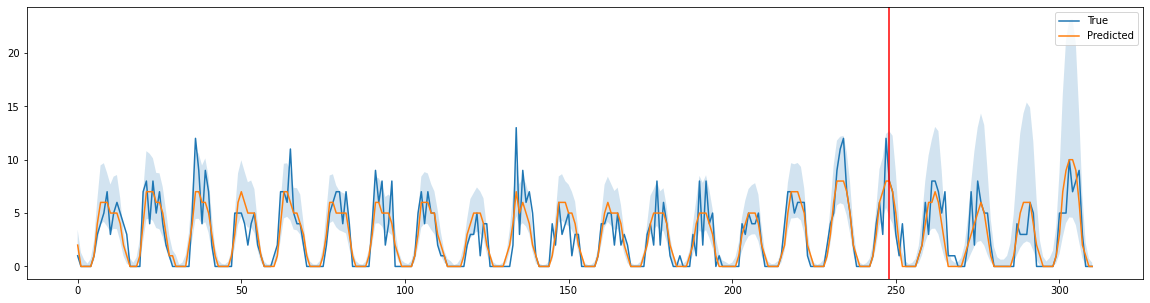

In [62]:
f_mean, f_var = m1._raw_predict(np.array(X_M1))
f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2*np.sqrt(f_var)

# For test sets
plt.figure(figsize=(20,5))
plt.plot(pd.DataFrame(y_M1.reshape(-1)),label='True')
plt.plot(pd.DataFrame(np.rint(np.exp(f_mean.reshape(-1)))),label='Predicted')
plt.fill_between(np.arange(len(X_M1)), np.exp(f_lower.reshape(-1)),np.exp(f_upper.reshape(-1)),alpha=0.2)
plt.legend()
plt.axvline(4*len(X_M1)//5,color='r')

- On the left of the vertical red line, it is for training data and on the right, it is for test data.

# Month 2

In [63]:
X_M2,y_M2 = data['M2'][:,:-1] , np.array([[y] for y in data['M2'][:,-1]])
X_M2_train,y_M2_train = X_M2[:4*len(X_M2)//5],y_M2[:4*len(X_M2)//5]

In [64]:
kernel_m1

sum.,value,constraints,priors
rbf.variance,0.02105249103054438,+ve,
rbf.lengthscale,1.0939910635877559,+ve,
rbf_1.variance,7.122968205915203,+ve,
rbf_1.lengthscale,3.4171423430679684,+ve,


In [65]:
kernel_m2_auto = GPy.kern.RBF(X_M2.shape[1]-3, variance=kernel_m1[0], lengthscale=kernel_m1[1],active_dims=[i for i in range(1,X_M2.shape[1]-2)])
kernel_m2_others = GPy.kern.RBF(3, variance=kernel_m1[2], lengthscale=kernel_m1[3], active_dims=[0,X_M2.shape[1]-2,X_M2.shape[1]-1])
kernel_m2 = kernel_m2_auto + kernel_m2_others

In [66]:
poisson_likelihood = GPy.likelihoods.Poisson()
laplace_inf = GPy.inference.latent_function_inference.Laplace()

In [67]:
m2 = GPy.core.GP(X=X_M2_train, Y=y_M2_train, likelihood=poisson_likelihood, inference_method=laplace_inf, kernel=kernel_m2)
print (m2)
#Predictions of counts of buses, including noise arising from Poisson noise


Name : gp
Objective : 405.53690812240455
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                    |                value  |  constraints  |  priors
  sum.rbf.variance       |  0.02105249103054438  |      +ve      |        
  sum.rbf.lengthscale    |   1.0939910635877559  |      +ve      |        
  sum.rbf_1.variance     |    7.122968205915203  |      +ve      |        
  sum.rbf_1.lengthscale  |   3.4171423430679684  |      +ve      |        


In [68]:
#m2.randomize()
m2.optimize()
print (m2)


Name : gp
Objective : 404.47111015899594
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                    |                  value  |  constraints  |  priors
  sum.rbf.variance       |  5.372647727421697e-07  |      +ve      |        
  sum.rbf.lengthscale    |     0.6885942703178852  |      +ve      |        
  sum.rbf_1.variance     |      4.999142569341727  |      +ve      |        
  sum.rbf_1.lengthscale  |     3.2379536905449458  |      +ve      |        


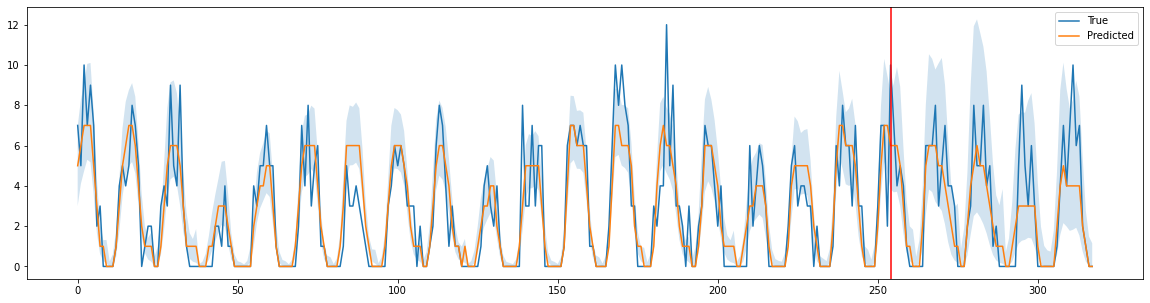

In [69]:
f_mean, f_var = m2._raw_predict(np.array(X_M2))
f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2*np.sqrt(f_var)

plt.figure(figsize=(20,5))
plt.plot(pd.DataFrame(y_M2.reshape(-1)),label='True')
plt.plot(pd.DataFrame(np.rint(np.exp(f_mean.reshape(-1)))),label='Predicted')
plt.fill_between(np.arange(len(X_M2)), np.exp(f_lower.reshape(-1)),np.exp(f_upper.reshape(-1)),alpha=0.2)
plt.legend()
plt.axvline(4*len(X_M2)//5,color='r')

- On the left of the vertical red line, it is for training data and on the right, it is for test data.

# Month 3

In [70]:
X_M3,y_M3 = data['M3'][:,:-1] , np.array([[y] for y in data['M3'][:,-1]])
X_M3_train,y_M3_train = X_M3[:2*len(X_M3)//3],y_M3[:2*len(X_M3)//3]

In [71]:
kernel_m2

sum.,value,constraints,priors
rbf.variance,5.372647727421697e-07,+ve,
rbf.lengthscale,0.6885942703178852,+ve,
rbf_1.variance,4.999142569341727,+ve,
rbf_1.lengthscale,3.2379536905449458,+ve,


In [73]:
kernel_m3_auto = GPy.kern.RBF(X_M3.shape[1]-3, variance=kernel_m2[0], lengthscale=kernel_m2[1],active_dims=[i for i in range(1,X_M3.shape[1]-2)])
kernel_m3_others = GPy.kern.RBF(3, variance=kernel_m2[2], lengthscale=kernel_m2[3], active_dims=[0,X_M3.shape[1]-2,X_M3.shape[1]-1])
kernel_m3 = kernel_m3_auto + kernel_m3_others

In [74]:
m3 = GPy.core.GP(X=X_M3_train, Y=y_M3_train, likelihood=poisson_likelihood, inference_method=laplace_inf, kernel=kernel_m3)
print (m3)


Name : gp
Objective : 421.02582592576914
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                    |                  value  |  constraints  |  priors
  sum.rbf.variance       |  5.372647727421697e-07  |      +ve      |        
  sum.rbf.lengthscale    |     0.6885942703178852  |      +ve      |        
  sum.rbf_1.variance     |      4.999142569341727  |      +ve      |        
  sum.rbf_1.lengthscale  |     3.2379536905449458  |      +ve      |        


In [75]:
#m3.randomize()
m3.optimize()
print (m3)


Name : gp
Objective : 420.0447447653074
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                    |                  value  |  constraints  |  priors
  sum.rbf.variance       |  5.375413237476901e-07  |      +ve      |        
  sum.rbf.lengthscale    |     0.6885945357333998  |      +ve      |        
  sum.rbf_1.variance     |      4.360803615244556  |      +ve      |        
  sum.rbf_1.lengthscale  |     3.6708690430218027  |      +ve      |        


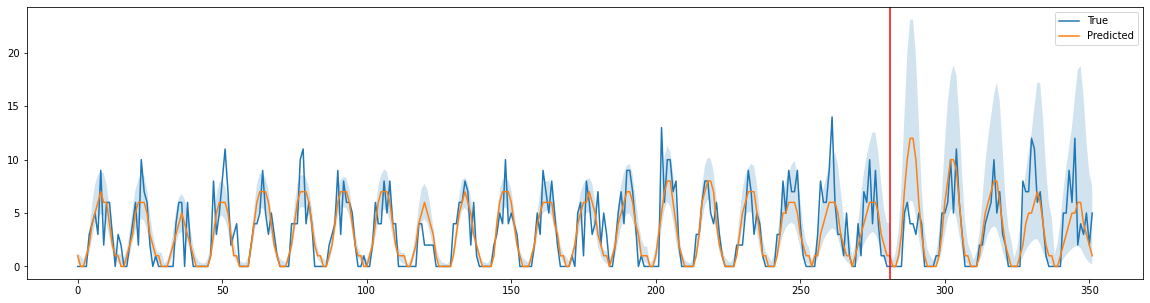

In [76]:
f_mean, f_var = m3._raw_predict(np.array(X_M3))
f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2*np.sqrt(f_var)

plt.figure(figsize=(20,5))
plt.plot(pd.DataFrame(y_M3.reshape(-1)),label='True')
plt.plot(pd.DataFrame(np.rint(np.exp(f_mean.reshape(-1)))),label='Predicted')
plt.fill_between(np.arange(len(X_M3)), np.exp(f_lower.reshape(-1)),np.exp(f_upper.reshape(-1)),alpha=0.2)
plt.legend()
plt.axvline(4*len(X_M3)//5,color='r')

- On the left of the vertical red line, it is for training data and on the right, it is for test data.